In [ ]:
!pip install pypulse
import matplotlib.pyplot as plt
from pypulse import SinglePulse
from scipy import signal
import numpy as np
import time as time_it
from scipy.stats import loguniform
from numpy import loadtxt
from scipy.signal import savgol_filter
import cProfile
from google.colab import files



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**The Pulse Broadening Function**: The Pulse Broadening function for the ISM when modeled as a thin sheet is given by: 

\begin{equation}
    g(t) = \tau_d^{-1} \exp (-\frac{t}{\tau_d}) U(t) 
\end{equation}

While there are other ways to model the ISM, such as assuming thick or uniform medium, the thin medium approximation was used for this work. Of particular importance in building the PBF is the use of the *scipy.signal.exponential* package in Python.

Using this function, we use the code below to make a one sided expoentail function. It is to be noted that while this function is not sensisitive to the bin size of the obervation, but rather the number of bins. Thus tau is in terms of bin size. In this case, the output, called the window, is given by:

\begin{equation}
    g(t) =  \exp (-\frac{n - center}{\tau})
\end{equation}

Thus, the code below uses our input tau, with tau in the same arbitrary units as the observation. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

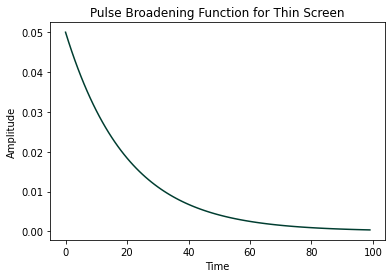

In [ ]:
'''
Pulse Broadening Function for thin sheet ISM
'''

def pfb(tau, time):
    return (1/tau)*signal.exponential(len(time), center=0, tau=tau, sym=False) #*(1/tau)




## uncomment To plot PBF for Tau and observation length of your choosing
"""
time = np.arange(0, 100.0, 1.0)
tau = 20.0
g_t_1 = pfb(tau, time)

plt.plot(time, g_t_1, color="#003D30")
plt.title("Pulse Broadening Function for Thin Screen")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.savefig("pbf_example.pdf", bbox_inches='tight')
files.download("pbf_example.pdf")

plt.show()

"""

**The Instrumental Response Function:** Moving through the ISM is not the only thing that changes the pulses of pulsars, the instruments we observe them with contribute to obscuring the intrinsic pulse as well. We quantify this chnage due to our instruments using the instrument response function, which itself is composed of different functions describing various instrumental effects on the observed pulse. However, the main change to the pulse due to the instrumental effects is in the determination of the resolution of the pulse, and therefore our search for the pulse broadening value tau will be limited by this function. If the amount of broadening due to the ISM is smaller than one bin size in the instrumental response function, we will only be able to determine an upper limit for tau, rather than finding the correct intrinsic value. 

While we will further explain the individual contribution function in the broader instrument response function, for the sake of simplicity, the instrument response function can be approximated as a delta function with a width of one bin step. This is how we approximate the contribution of this function within this work. 

However, this component can be expanded upon in further work, with unique instrument response functions developed for each major radio observatory and then applied to real observational data taken with these telescopes. 

The effective pulse phase can be determined by convolving functions that describe contributing instrumental effects to form the instrument resolution function. The main effects to be considered include the dispersion smearing ($r_{dm}$), the profile binning ($r_{pb}$), the back-end time averaging ($r_{av}$), and any additional time averaging occurring post-detection ($r_{pd}$). We determine that a delta function is a good approximation for the convolutionaly combined function, as each of these functions can be treated as roughly rectangular, which when combined will form a roughly trapezoidal function very similar to a delta function with a width of one bin step.


\begin{equation}
   r(t) = r_{dm}(t) \otimes r_{pb}(t) \otimes r_{av}(t) \otimes r_{pd}(t)
\end{equation}

The location of the delta function peak is at the location of the max of the input data, which in this case a Gaussian pulse. This is done to simplify the convolution process.

In [ ]:
'''
Instrument response function
'''

def inst_resp(new_pulse_profile):
    r_t_before = np.zeros(len(new_pulse_profile))
    r_t_before[np.argmax(new_pulse_profile)] = 1.0
    return r_t_before

"""
## uncomment To plot Instrument Response Function for an observation length of your choosing, random gaussian is used for this observation
time = np.arange(0, 100.0, 1.0)
std = 1.0

pulse = signal.gaussian(len(time), std=std)
inst_resp = inst_resp(pulse)

plt.plot(time, inst_resp, color="#003D30")
plt.title("Instrument Response Function")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.savefig("inst_resp.pdf", bbox_inches='tight')
files.download("inst_resp.pdf")
plt.show()

"""



'\n## uncomment To plot Instrument Response Function for an observation length of your choosing, random gaussian is used for this observation\ntime = np.arange(0, 100.0, 1.0)\nstd = 1.0\n\npulse = signal.gaussian(len(time), std=std)\ninst_resp = inst_resp(pulse)\n\nplt.plot(time, inst_resp, color="#003D30")\nplt.title("Instrument Response Function")\nplt.ylabel("Amplitude")\nplt.xlabel("Time")\nplt.savefig("inst_resp.pdf", bbox_inches=\'tight\')\nfiles.download("inst_resp.pdf")\nplt.show()\n\n'

In [ ]:
'''
Characteristics for each simulated pulsar, height is not included as pulse will be normalized
'''

def characteristics(): 
    length_of_obs = 100 
    n_bins = 100

    FWHM = 1.0  
    std = round((FWHM)/2.35, 5)

    tau =  20.0 
    SN = 100

    return length_of_obs, FWHM, std, tau, SN, n_bins

**The Intrinsic Pulse:** In our simulated data, we must build the intrinsic pulse. As discussed in Chapter 3 of this thesis, we know that assuming a Gaussian pulse shape for intrinsic emission is a decision based on only the most simplistic models of pulsar emission, and that real pulsar pulse profiles rarely fit a perfect Gaussian mold. However, for this work, we use exclusively Gaussian intrinsic pulses, as is also done in Bhat. et. al. 2003. It is to be noted here that one of the three main figures of merit in Bhat. et. al. 2003. is based on a measurement of the skewness of each recovered pulse for each tau. Thus, in order to employ this figure of merit, a simple, single peak Gaussian pulse model must be assumed. Future work could done in this vein to develop a figure of merit to replace the skewness measure that does not require the intrinsic pulse to be a symmetric Gaussian. However, in this analysis we have decided to use only single peak Gaussian intrinsic pulses in order to replicate the results given within  Bhat. et. al. 2003.

We determine the length of our observation, the number of bins, and the standard deviation of our desired Gaussian, and use *scipy.signal.gaussian* to create our intrinsic Gaussian pulse. It is to be noted here that we do not determine the height of the pulse, as the data will be normalized. 

In pulsar astronomy, we can measure the full width at half maximum of our observed pulses. Thus, we can use the known ranges of FWHMs to generate reasonable standard deviations of the intrinsic Gaussian pulses via the standard relationship between FWHM and STD:

\begin{equation}
   FWHM = 2.355\sigma
\end{equation}

where $\sigma$ is the standard deviation of our intrinsic pulse. 


In [ ]:
def intrinsic_pulse(length_of_obs, n_bins, std, time):
    intrinsic_pulse = signal.gaussian(len(time), std=std/(length_of_obs/n_bins))
    return intrinsic_pulse



## uncomment To plot Intrinsic pulse. Pulse parameters are determined via the "characteristics" function.
"""
length_of_obs, FWHM, std, tau, SN, n_bins = characteristics()
time = np.arange(0, length_of_obs, length_of_obs/n_bins)

intrinsic_pulse = intrinsic_pulse(length_of_obs, n_bins, std, time)

plt.plot(time, intrinsic_pulse, color="#003D30")
plt.title("Intrinsic Pulse")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.savefig("intrinsic_pulse.pdf", bbox_inches='tight')
files.download("intrinsic_pulse.pdf")
plt.show()
"""
  


'\nlength_of_obs, FWHM, std, tau, SN, n_bins = characteristics()\ntime = np.arange(0, length_of_obs, length_of_obs/n_bins)\n\nintrinsic_pulse = intrinsic_pulse(length_of_obs, n_bins, std, time)\n\nplt.plot(time, intrinsic_pulse, color="#003D30")\nplt.title("Intrinsic Pulse")\nplt.ylabel("Amplitude")\nplt.xlabel("Time")\nplt.savefig("intrinsic_pulse.pdf", bbox_inches=\'tight\')\nfiles.download("intrinsic_pulse.pdf")\nplt.show()\n'

**The Observed Pulse**: The Observed Pulse is created by convolving the intrinsic pulse, the pulse broadening function, and the instrumental response function together, and then adding noise to the resulting pulse to mimic real observational data. We use *np.convolve* to convolve our functions using discrete convolution. 

The discrete convolution operation used in *np.convolve* is defined as:


\begin{equation}
   (a * v)[n] = \Sigma_{m = - \infty}^{\infty} a[m]v[n-m]
\end{equation}

Additionally, there are three modes that can be used with this function: ‘full’, ‘valid’, and ‘same’. Both input arrays must be the same length in all modes. We use modes 'same' and 'full' in this work. 

The default value is 'full', which returns convolution at each point of overlap, which essentially doubles the length of the output array when compared to the input array. This mode is used when one or both of the peaks of the input arrays are centered at 0 instead of in the middle of their respective arrays, and then the output array is cut to be the same length as the input arrays. As the signals do not overlap fully at the end-points, boundary effects can be seen. 


When the mode value is set to 'same', an array of the same length as the input arrays is returned. This can be used if the peaks of both arrays are centered in the middle of their respective arrays. The mode is still susceptible to boundary effects. 

We first convolve the intrinsic pulse array and the pulse broadening function array together, and then convolve the result of this first convolution with out instrument response function to give us out observed array should there be no noise in the observation. Then using the *SinglePulse* function in the library *PyPulse*, we add in random Gaussian noise to our observed pulse by specifying a signal to noise level we wish our final result to have. We then subtract of the noise baseline determined using the off pulse region, and find the root mean squared of the data by using the *SinglePulse.getOffpulseNoise()* function in PyPulse. We then finally have our simulated observed pulsar profile.


 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

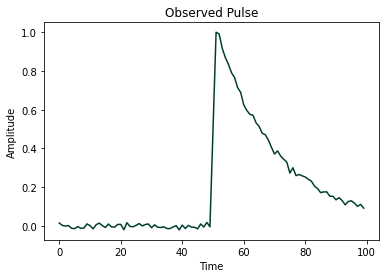

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

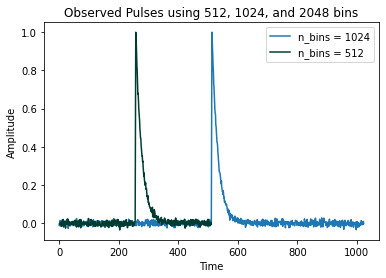

In [ ]:
'''
Creating the Observed Pulse
'''

def observed_pulse(tau, std, length_of_obs, n_bins):

    ## Create our time array and intrinsic pulse
    time = np.arange(0, length_of_obs, length_of_obs/n_bins)
    g_t = intrinsic_pulse(length_of_obs, n_bins, std, time)

    # Create our pulse broadening function
    pbf_1 = pfb(tau,time)

    #First convolution. Convolve the intrinsic pulse and the pulse broadening function together//
    #Since the pbf in centered at 0, the np.convolve "same" tag can not be used, thus we must cut the //
    #off the second half of the convolved pulse, as it is just the further tail of the convolved pulse //
    #and doesn't include the pulse peak.

    new_pulse_profile = np.convolve(g_t, pbf_1)
    new_pulse_profile = new_pulse_profile[0:int(len(time))]
     
    #Create Instrument response function 
    r_t =  inst_resp(new_pulse_profile)

    #Second convolution. Convolve the first convolution of the intrinsic pulse and //
    #the pulse broadening function together with the instrument response function. //
    #this is the observed pulse if there is no noise.

    before_noise_obs_pulse = np.convolve(new_pulse_profile, r_t, 'same')

    #Using PyPulse, we add noise to our observed pulse.
    sp_noise = SinglePulse(before_noise_obs_pulse, windowsize=int(len(before_noise_obs_pulse) / 8))
    with_noise_obs_pulse = sp_noise.addNoise(SN, save=True)

    #Using PyPulse, we subtract off our baseline
    sp_off_pulse = SinglePulse(with_noise_obs_pulse, windowsize=int(len(with_noise_obs_pulse) / 8))
    off_pulse = sp_off_pulse.calcOffpulseWindow()
    sp_off_pulse.remove_baseline()

    ## Normalize observation
    obs_pulse = with_noise_obs_pulse/np.max(with_noise_obs_pulse)

    ### Calculate rms of baseline subtracted, normalized observation
    sp_rms = SinglePulse(obs_pulse, windowsize=int(len(obs_pulse) / 8))
    rms = sp_rms.getOffpulseNoise()
    return obs_pulse, time, rms, off_pulse, intrinsic_pulse 


## uncomment to plot the observed pulse. Pulse parameters are determined via the "characteristics" function 

"""
length_of_obs, FWHM, std, tau, SN, n_bins = characteristics()

data_file, time, rms, off_pulse, amp  = observed_pulse(tau, std, length_of_obs, n_bins)
plt.plot(time, data_file,  color = "#003D30")
plt.title("Observed Pulse")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.savefig("observed_pulse.pdf", bbox_inches='tight')
files.download("observed_pulse.pdf")
plt.show()

"""


**Finding CLEAN Components**: In this method of CLEAN Deconvolution requires iterative subtraction of Clean Components (CCs) off of the main pulse. In order to create the CCs, we convolve a delta function with amplitude of the pulse multiplied by a gain value, in this case being 5 percent, at the location of the peak of the pulse profile, with the instrumental response function, and the pulse broadening function with a test tau. 

With each iteration, the pulse profile resulting from the last iteration becomes the pulse profile for the next iteration. Thus the change in the profile at each iteration is described as such: 

\begin{equation}
   \Delta y(t_i) = y(t_i) - \{y_c(t) \otimes [g(t) \otimes r(t)]\}_{i = t_i}, i = 1,..., N
\end{equation}

with $y(t_i)$ as the input pulse profile, $y_c(t)$ is the delta function with height of five percent of input pulse profile, $g(t)$ is the pulse broadening function, and $r(t)$ is the instrumental response function. This process is continues until either the max of the input pulse profile is below the root mean squared of the noise in the profile or the number of iterations reaches the number of bins in the profile. The location and height of these CLEAN components are then saved in order to rebuild to intrinsic pulse. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

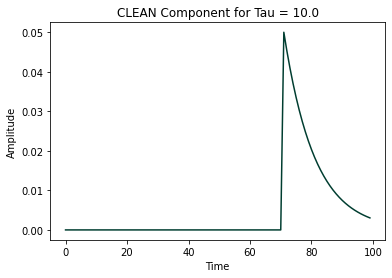

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

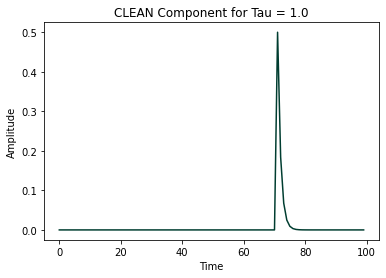

In [ ]:

'''
Convolutions called in the loop
'''


def looped_convs(pulse_profile, tau_1, index_pulse_profile):

    # call function to create instrument response function
    r_t = inst_resp(pulse_profile)

    # Create delta function, with height equal to and location at the max of the data profile. Then multiply //
    # by chosen gain. In this case 0.05. 
    y_t = np.zeros(len(pulse_profile))
    y_t[index_pulse_profile] = pulse_profile[index_pulse_profile]

    gain = 0.05
    y_t = gain * y_t

    #convolve gain delta function and instrument response function
    conv_one = np.convolve(y_t, r_t)
 
    #Create Pulse Broadening Function
    g_t_1 = pfb(tau_1, conv_one)
    #g_t_1 = g_t_1/max(g_t_1)

    #Second Convolution
    conv_two =  np.convolve(conv_one, g_t_1)
 
    #Cut window to correct size, while maintaining correct index of peak
    peak = np.argmax(conv_two)
    conv_two = conv_two[peak - index_pulse_profile: len(time) + index_pulse_profile ]

    return conv_two, y_t, g_t_1


## uncomment to plot the one CLEAN component. Pulse parameters are determined via the "characteristics" function 
"""

length_of_obs, FWHM, std, tau, SN, n_bins = characteristics()
data_file, time, rms, off_pulse, amp  = observed_pulse(tau, std, length_of_obs, n_bins)
pulse_profile = data_file
index_pulse_profile = np.argmax(pulse_profile)
conv_two, y_t, g_t_1 = looped_convs(pulse_profile, tau, index_pulse_profile)


plt.plot(time, conv_two, color="#003D30")
plt.title("CLEAN Component for Tau = 1.0")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.savefig("CC_tau_1.pdf", bbox_inches='tight')
files.download("CC_tau_1.pdf")
plt.show()
"""

**Calculating Positivity**: Positivity is used in this work as a Figure of Merit to determine which input tau that best describes the amount by which the observed pulse is broadened by the ISM. Positivity refers to the amount of over-subtraction or under-subtraction caused by using a tau too small or too large to describe the contribution of the ISM. Over-subtraction will lead to a negative pulse shape on the right side of the pulse where we see the broadening effect, while under-subtraction will result in a residual pulse with values larger than zero to the right side of the profile. 

We calculate the positivity with with the following equation:

\begin{equation}
   f_r = \frac{m}{N \sigma_{off}^2} \Sigma_{i = 1}^N [\Delta y (t_i) ]^2 U_{\Delta y}
\end{equation}

Where $U_{\Delta y}$ is found via:

\begin{equation}
   U_{\Delta y} = U [- \Delta y(t_i) - x \sigma_{off}]
\end{equation}


Here, $x$ is arbitrarily chosen to be $\frac{3}{2}$ to penalize values of tau larger than the correct value, and $m$, which is only refered to as "a weight of order unity" is chosen to be 1. $\Delta y$ is the residual noise left over a the end of the iterative CLEAN process, $\theta$ is the root mean squared of the off pulse noise, and $U$ is a Heaviside function. 



In [ ]:
'''
Calculate Positivity
'''

def fr(res_noise, rms):
    f_r = (1.0 / ((len(res_noise)) * (rms ** 2))) * np.sum(((res_noise) ** 2) * np.heaviside(-res_noise - ((3.0 / 2.0) * rms), 0.0))
    return f_r  


**Calculating Skewness:** Skewness is the measure of how symmetric a distribution, which in this case is our rebuilt Gaussian intrinsic pulse, is. Again, the use of this figure of merit relies on the assumption that intrinsic pulses are inherently Gaussian, which we know holds true for only a small handful of pulsars at some frequencies. However, as we know that our simulated data uses a Gaussian pulse for the intrinsic pulsar emission, this figure of merit will hold for this simulated, proof of concept work.  

Positive skew indicates an imbalance to the right hand side of the distribution, while negative skew indicates an imbalance to the left hand side. In this work, the broadening results in a broadening tail to the right hand side of the peak of the pulse. Thus, we should expect an over-subtraction due to choosing a tau that is too large to describe the broadening effects to result in a rebuilt intrinsic pulse with a negative skew value, under-subtraction due to choosing too small of a tau to result in a positive skew value, and the correct tau resulting in a rebuilt pulse with a skew value of zero. 

The skewness of the rebuilt pulses is calculated for each test tau using the following equation: 

\begin{equation}
   \Gamma = \frac{t^3}{(t^2)^\frac{3}{2}}
\end{equation}

where $t^n$ is calculated using:

\begin{equation}
   t^n = \frac{\Sigma_{i = 1}^{n_c} (t_i - \bar{t})^n C_i}{\Sigma_{i = 1}^{n_c} C_i}
\end{equation}

and $\bar{t}$ is calculated via:


\begin{equation}
   \bar{t} = \frac{\Sigma_{i = 1}^{n_c} t_i C_i}{\Sigma_{i = 1}^{n_c} C_i}
\end{equation}

where $C_i$ and $t_i$ are the amplitudes and the locations of the CLEAN components that make up the recovered intrinsic, respectively. 


In [ ]:
'''
Calculate Skewness
'''

def gamma(amps, times):
    sum_t_c = sum(np.multiply(amps, times))
    sum_c = sum(amps)

    t_bar = sum_t_c / sum_c

    t_3 = sum(np.multiply(((times - t_bar) ** 3), amps)) / sum_c
    t_2 = sum(np.multiply(((times - t_bar) ** 2), amps)) / sum_c

    sym = t_3 / (t_2 ** (3 / 2))
    return sym



**Calculate $N_f$**: The number of residual points in the on-pulse window that are consistent with the noise level of the off pulse window is also calculated, with the goal being to maximize this number for the correct tau. This is achieved by counting the number of points that satisfy: 

\begin{equation}
   | y_i - y_{off}| \leq 3\sigma_{off}
\end{equation}

where $y_{off}$ is the mean of the off-pulse noise and $\sigma_{off}$ is the root mean squared of the off-pulse noise. 

In [ ]:
'''
Calculate N_f
'''
def N_f(res_noise):
    index = np.argmax(data_file)
    mean_res_array = []

    for i in off_pulse:
        
        mean_res_array.append(data_file[i])
    mean_off_pulse = np.mean(mean_res_array)
    N_f = 0

    for i, j in enumerate(res_noise):
        if i not in off_pulse:
            if np.abs(j - mean_off_pulse) <= 3 * rms:
                N_f = N_f + 1
    return N_f



We now use the CLEAN algorithum, running through each test value of tau, iterativly subracting CLEAN componets off the observed pulse profile until the max value of the pulse profile is smaller than the root mean squared of the off pulse noise or until the number of iterations ellapsed reaches the number of bins in the profile. 

In [ ]:
'''
CLEAN loop
'''


def CLEAN_Loop(tau_array):

    ## arrays to append the calculated values for the figures of merit to
    positivity = []
    skewness = []
    number_of_loops = []
    rms_residual_to_off_pulse = []
    points_above_noise = []

    for tau_1 in tau_array:

        #arrays to append the values of the CLEAN Components to
        C_all = []
        C_index_all = []

        #set the pulse profile equal to the simulated observed pulse profile
        pulse_profile = data_file

        #iteration counter
        n = 0
        
        #find index of the peak of the profile
        pulse_profile_max_index = np.argmax(pulse_profile)


        #continue the iteration until the max value is less than the rms of the off-pulse noise or 
        #until the number of iterations equals the number of bins in the profile
        while (pulse_profile[pulse_profile_max_index]) > rms or n < len(data_file):

                #Create CLEAN Component 
                conv_two, y_t, g_t_1 = looped_convs(pulse_profile, tau_1, pulse_profile_max_index)

                #Record index and amplitude of the CLEAN Component
                C_all.append(y_t[pulse_profile_max_index])
                C_index_all.append(pulse_profile_max_index)
          
                #subtract the CLEAN Component from the pulse profile
                pulse_profile = np.subtract(pulse_profile, conv_two)

                #set the new pulse profile to be the residual noise, the last iteration will assign this to the correct version of the array
                res_noise = pulse_profile

                #add one to our iteration counter
                n = n + 1

                #set a new value for the index of the peak of the profile
                pulse_profile_max_index = np.argmax(pulse_profile)

        ##Uncomment to get rebuilt intrinsic pulse
        
        uniq_index = np.unique(C_index_all)
        values_added = np.zeros((len(time)))
        
        for index, value in enumerate(C_index_all): 
            for index_2, value_2 in enumerate(uniq_index):  
                if value == value_2:
                   values_added[value_2] = values_added[value_2] + C_all[index]
                            # print(C_all[index])
        restoring = signal.gaussian(len(time), std=1.0 )#/2.35)
        if tau_1 == tau:

           before_restore = values_added
  

        final_restored_2 = np.convolve(values_added, restoring, "same")
        if tau_1 == tau:
           keep_restored = final_restored_2
      
           

        number_of_loops.append(n)
        rms_res = np.sqrt(np.mean(np.multiply(res_noise, res_noise)))
        rms_residual_to_off_pulse.append(rms_res/rms)
        points_above_noise .append(N_f(res_noise))
        skewness.append(gamma(C_all, C_index_all))  
        positivity.append(fr(res_noise, rms))

    return positivity, skewness, number_of_loops, rms_residual_to_off_pulse, points_above_noise, keep_restored, before_restore





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

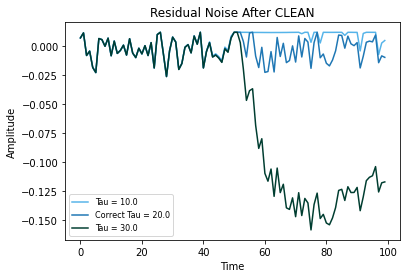

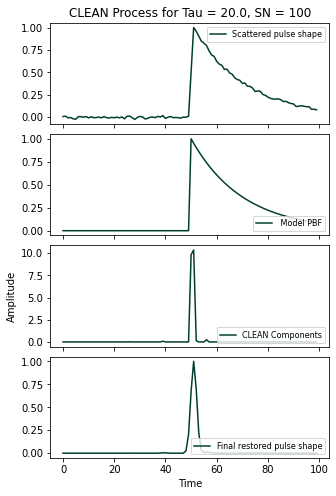

In [ ]:
'''
Run CLEAN for mulitple diffrent test taus
'''


for i in np.arange(0, 1):
    length_of_obs, FWHM, std, tau, SN, n_bins = characteristics()

    data_file, time, rms, off_pulse, amp = observed_pulse(tau, std, length_of_obs, n_bins)
    
    tau_array = np.arange(1.0, 100.0, 1.0)

    positivity, skewness, number_of_loops, rms_residual_to_off_pulse, points_above_noise, keep_restored, before_restored = CLEAN_Loop(tau_array)


    combined_pos_skew = np.add(positivity, skewness) / 2
    """
    #Replicate Fig 1 form Bhat et. al. 2003
    centered_pfb = (1/tau)* signal.exponential(len(time), center=int(len(time)/2), tau=tau, sym=False)
    centered_pfb[0:np.argmax(centered_pfb)]  = 0
    fig, axs = plt.subplots(4, figsize=(5, 8), sharex=True, sharey=False, gridspec_kw={'wspace': 0, 'hspace': 0.1})
    axs[0].plot(time, data_file/max(data_file),  color="#003D30",label="Scattered pulse shape")
    axs[0].legend(loc='upper right', fontsize="8")
    axs[1].plot(time, centered_pfb/max(centered_pfb), color="#003D30", label=" Model PBF")
    axs[1].legend(loc='lower right', fontsize="8")  
    axs[2].plot(time, before_restored, color="#003D30",label="CLEAN Components")
    axs[2].legend(loc='lower right', fontsize="8")    
    axs[3].plot(time, keep_restored/max(keep_restored), color="#003D30", label="Final restored pulse shape")
    axs[3].legend(loc='lower right', fontsize="8") 
    axs[3].set_xlabel('Time')
    axs[2].set_ylabel('Amplitude')
    axs[0].title.set_text('CLEAN Process for Tau = {}, SN = {}'.format(tau, SN))
    plt.tight_layout()
    plt.savefig("copy_fig_3_bhat.pdf", bbox_inches='tight')
    files.download("copy_fig_3_bhat.pdf")
  
    """





To automate the process of finding the best tau using the figures of merit, we find the jerk, or the third derviative, of each FOM array. 

20.0 19.0 21 18.0 22.0 Correct Tau =  20.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

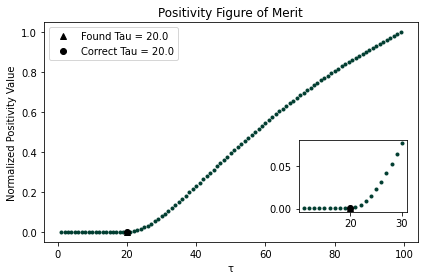

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

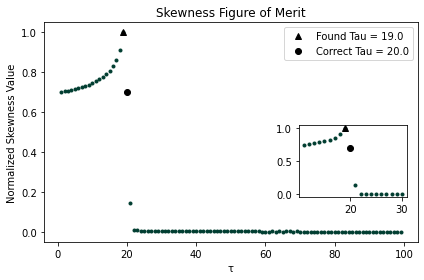

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

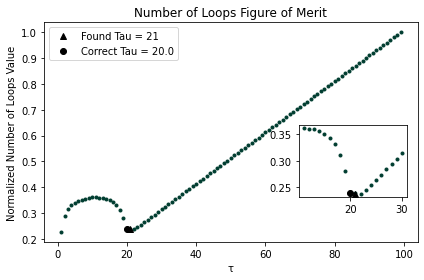

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

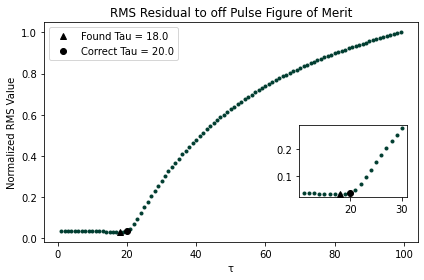

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

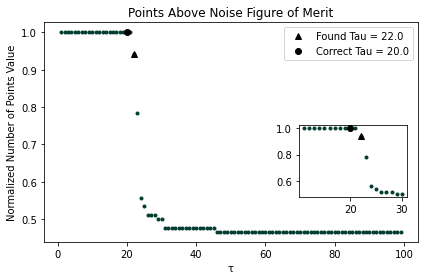

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

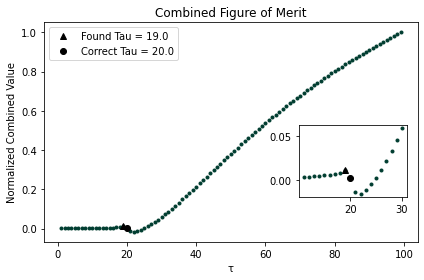

In [ ]:
"""
Finding the jerk of each FOM
"""

def jerk(array):

        first_diff = np.diff(array)
        second_diff = np.diff(first_diff)
        third_diff = np.diff(second_diff)

        max_index = np.argmax(third_diff)
        second_tau = tau_array[max_index]
        return second_tau

### Uncoment to plot each FOM 

points_above_noise = np.asarray(points_above_noise )
rms_residual_to_off_pulse = np.asarray(rms_residual_to_off_pulse)
skewness = np.asarray(skewness)
positivity = np.asarray(positivity)
combined_pos_skew = np.asarray(combined_pos_skew)
number_of_loops = np.asarray(number_of_loops)


normalize_positivity = (positivity) / max((positivity))
normalize_skewness = (skewness + abs(min(skewness)))/ max((skewness + abs(min(skewness))))
normalize_points_above_noise = (points_above_noise)/max(points_above_noise)
normalize_rms_residual_to_off_pulse = (rms_residual_to_off_pulse)/max(rms_residual_to_off_pulse)
normalize_number_of_loops = (number_of_loops) / max((number_of_loops))
normalize_combined_pos_skew = (combined_pos_skew) / max((combined_pos_skew))

positivity_jerk = jerk(normalize_positivity)
skewness_jerk = jerk(normalize_skewness)
#number_of_loops_jerk = jerk(normalize_number_of_loops)
rms_residual_to_off_pulse_jerk = jerk(normalize_rms_residual_to_off_pulse)
points_above_noise_jerk = jerk(normalize_points_above_noise )
combined_pos_skew_jerk = jerk(normalize_combined_pos_skew)




location = 0

for i,j in enumerate(normalize_number_of_loops):
        #print(i,j)
        #print(len(normalize_number_of_loops) - 1)
        if i != 0 and i != (len(normalize_number_of_loops) - 1):
           #print(j, normalize_number_of_loops[i - 1],  normalize_number_of_loops[i + 1] )
           #print(i,j)
  
           if j < normalize_number_of_loops[i - 1] and j < normalize_number_of_loops[i + 1]:
                    
                    location = i

number_of_loops_jerk = location  




print(positivity_jerk, skewness_jerk, number_of_loops_jerk, rms_residual_to_off_pulse_jerk, points_above_noise_jerk, "Correct Tau = ", tau)


plt.plot(tau_array, normalize_positivity, ".", color="#003D30")
plt.plot(positivity_jerk, normalize_positivity[int(positivity_jerk) -1], "^", color = "black", label="Found Tau = {}".format(positivity_jerk))
plt.plot(tau, normalize_positivity[int(tau) -1], "o", color = "black", label = "Correct Tau = {}".format(tau))
plt.title("Positivity Figure of Merit")
plt.ylabel("Normalized Positivity Value")
plt.xlabel("\u03C4")
plt.legend()
axes = plt.axes([0.7, 0.25, 0.25, 0.25]) #x location, y location, width, height
axes.plot(tau_array[int(tau) - 10: int(tau) + 10 ], normalize_positivity[int(tau) - 10: int(tau) + 10 ], ".", c='#003D30', lw=1, label="Zoomed curve")
axes.plot(positivity_jerk, normalize_positivity[int(positivity_jerk) -1], "^", color = "black")
axes.plot(tau, normalize_positivity[int(tau) -1], "o", color = "black")
#axes.legend()
plt.tight_layout()
plt.savefig("pos_fom.pdf", bbox_inches='tight')
files.download("pos_fom.pdf")

plt.show()




plt.plot(tau_array, normalize_skewness, ".", color="#003D30")
plt.plot(skewness_jerk, normalize_skewness[int(skewness_jerk) -1], "^", color = "black", label="Found Tau = {}".format(skewness_jerk))
plt.plot(tau, normalize_skewness[int(tau) -1], "o", color = "black", label = "Correct Tau = {}".format(tau))
plt.title("Skewness Figure of Merit")
plt.ylabel("Normalized Skewness Value")
plt.xlabel("\u03C4")
plt.legend()
axes = plt.axes([0.7, 0.30, 0.25, 0.25]) #x location, y location, width, height
axes.plot(tau_array[int(tau) - 10: int(tau) + 10 ], normalize_skewness[int(tau) - 10: int(tau) + 10 ], ".", c='#003D30', lw=1, label="Zoomed curve")
axes.plot(skewness_jerk, normalize_skewness[int(skewness_jerk) -1], "^", color = "black")
axes.plot(tau, normalize_skewness[int(tau) -1], "o", color = "black")
#axes.legend()
plt.tight_layout()
plt.savefig("skew_fom.pdf", bbox_inches='tight')
files.download("skew_fom.pdf")
plt.show()

#num_of_loops_fom
plt.plot(tau_array, normalize_number_of_loops, ".", color="#003D30")
plt.plot(number_of_loops_jerk, normalize_number_of_loops[int(number_of_loops_jerk)], "^", color = "black", label="Found Tau = {}".format(number_of_loops_jerk))
plt.plot(tau, normalize_number_of_loops[int(tau)], "o", color = "black", label = "Correct Tau = {}".format(tau))
plt.title("Number of Loops Figure of Merit")
plt.ylabel("Normalized Number of Loops Value")
plt.xlabel("\u03C4")
plt.legend()
axes = plt.axes([0.7, 0.30, 0.25, 0.25]) #x location, y location, width, height
axes.plot(tau_array[int(tau) - 10: int(tau) + 10], normalize_number_of_loops[int(tau) - 10: int(tau) +  10], ".", c='#003D30', lw=1, label="Zoomed curve")
axes.plot(number_of_loops_jerk, normalize_number_of_loops[int(number_of_loops_jerk)], "^", color = "black")
axes.plot(tau, normalize_number_of_loops[int(tau)], "o", color = "black")
#axes.legend()
plt.tight_layout()
plt.savefig("example_without_one_over_tau.pdf", bbox_inches='tight')
files.download("example_without_one_over_tau.pdf")
plt.show()


plt.plot(tau_array, normalize_rms_residual_to_off_pulse, ".", color="#003D30")
plt.plot(rms_residual_to_off_pulse_jerk, normalize_rms_residual_to_off_pulse[int(rms_residual_to_off_pulse_jerk) -1], "^", color = "black", label="Found Tau = {}".format(rms_residual_to_off_pulse_jerk))
plt.plot(tau, normalize_rms_residual_to_off_pulse[int(tau) -1], "o", color = "black", label = "Correct Tau = {}".format(tau))
plt.title("RMS Residual to off Pulse Figure of Merit")
plt.ylabel("Normalized RMS Value")
plt.xlabel("\u03C4")
plt.legend()
axes = plt.axes([0.7, 0.30, 0.25, 0.25]) #x location, y location, width, height
axes.plot(tau_array[int(tau) - 10: int(tau) + 10], normalize_rms_residual_to_off_pulse[int(tau) - 10: int(tau) +  10], ".", c='#003D30', lw=1, label="Zoomed curve")
axes.plot(rms_residual_to_off_pulse_jerk, normalize_rms_residual_to_off_pulse[int(rms_residual_to_off_pulse_jerk) -1], "^", color = "black")
axes.plot(tau, normalize_rms_residual_to_off_pulse[int(tau) -1], "o", color = "black")
#axes.legend()
plt.tight_layout()
plt.savefig("rms_fom.pdf", bbox_inches='tight')
files.download("rms_fom.pdf")
plt.show()

plt.plot(tau_array, normalize_points_above_noise, ".", color="#003D30")
plt.plot(points_above_noise_jerk, normalize_points_above_noise[int(points_above_noise_jerk) -1], "^", color = "black", label="Found Tau = {}".format(points_above_noise_jerk))
plt.plot(tau, normalize_points_above_noise[int(tau) -1], "o", color = "black", label = "Correct Tau = {}".format(tau))
plt.title("Points Above Noise Figure of Merit")
plt.ylabel("Normalized Number of Points Value")
plt.xlabel("\u03C4")
plt.legend()
axes = plt.axes([0.7, 0.30, 0.25, 0.25]) #x location, y location, width, height
axes.plot(tau_array[int(tau) - 10: int(tau) + 10], normalize_points_above_noise[int(tau) - 10: int(tau) +  10], ".", c='#003D30', lw=1, label="Zoomed curve")
axes.plot(points_above_noise_jerk, normalize_points_above_noise[int(points_above_noise_jerk) -1], "^", color = "black")
axes.plot(tau, normalize_points_above_noise[int(tau) -1], "o", color = "black")
#axes.legend()
plt.tight_layout()
plt.savefig("points_fom.pdf", bbox_inches='tight')
files.download("points_fom.pdf")
plt.show()

plt.plot(tau_array, normalize_combined_pos_skew, ".", color="#003D30")
plt.plot(combined_pos_skew_jerk, normalize_combined_pos_skew[int(combined_pos_skew_jerk) -1], "^", color = "black", label="Found Tau = {}".format(combined_pos_skew_jerk))
plt.plot(tau, normalize_combined_pos_skew[int(tau) -1], "o", color = "black", label = "Correct Tau = {}".format(tau))
plt.title("Combined Figure of Merit")
plt.ylabel("Normalized Combined Value")
plt.xlabel("\u03C4")
plt.legend()
axes = plt.axes([0.7, 0.30, 0.25, 0.25]) #x location, y location, width, height
axes.plot(tau_array[int(tau) - 10: int(tau) + 10], normalize_combined_pos_skew[int(tau) - 10: int(tau) +  10], ".", c='#003D30', lw=1, label="Zoomed curve")
axes.plot(combined_pos_skew_jerk, normalize_combined_pos_skew[int(combined_pos_skew_jerk) -1], "^", color = "black")
axes.plot(tau, normalize_combined_pos_skew[int(tau) -1], "o", color = "black")
#axes.legend()
plt.tight_layout()
plt.savefig("combo_fom.pdf", bbox_inches='tight')
files.download("combo_fom.pdf")
plt.show()


0.2875338142470694
0.3598963029756537
0.3586564472497746
0.3556131650135257
0.35099188458070335
0.3431018935978359
0.3307033363390442
0.31052750225428316
0.28043282236248873
0.23816501352569883
0.23872858431018937
0.2377141568981064
20.0 19.0 20 18.0 22.0 19.0 Correct Tau =  20.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

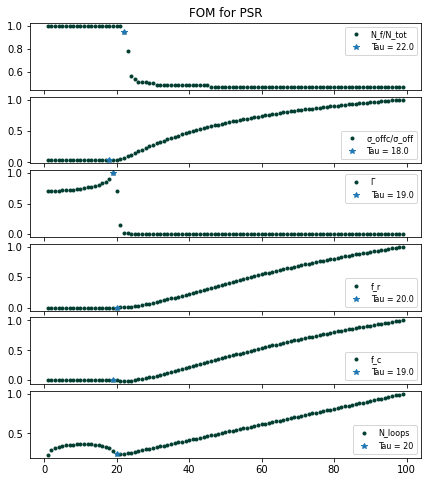

In [ ]:
points_above_noise = np.asarray(points_above_noise )
rms_residual_to_off_pulse = np.asarray(rms_residual_to_off_pulse)
skewness = np.asarray(skewness)
positivity = np.asarray(positivity)
combined_pos_skew = np.asarray(combined_pos_skew)
number_of_loops = np.asarray(number_of_loops)

positivity_jerk = jerk(positivity)
skewness_jerk = jerk(skewness)
#number_of_loops_jerk = jerk(number_of_loops)
rms_residual_to_off_pulse_jerk = jerk(rms_residual_to_off_pulse)
points_above_noise_jerk = jerk(points_above_noise )
combined_pos_skew_jerk = jerk(combined_pos_skew)

normalize_positivity = (positivity) / max((positivity))
normalize_skewness = (skewness + abs(min(skewness)))/ max((skewness + abs(min(skewness))))
normalize_points_above_noise = (points_above_noise)/max(points_above_noise)
normalize_rms_residual_to_off_pulse = (rms_residual_to_off_pulse)/max(rms_residual_to_off_pulse)
normalize_number_of_loops = (number_of_loops) / max((number_of_loops))
normalize_combined_pos_skew = (combined_pos_skew) / max((combined_pos_skew))


location = 0

for i,j in enumerate(normalize_number_of_loops[1:len(normalize_number_of_loops) - 1]):

        if j < normalize_number_of_loops[i - 1] and j < normalize_number_of_loops[i - 1]:
             print(j)
             if i > location:
                    location = i

number_of_loops_jerk = location  


print(positivity_jerk, skewness_jerk, number_of_loops_jerk, rms_residual_to_off_pulse_jerk, points_above_noise_jerk, combined_pos_skew_jerk, "Correct Tau = ", tau)

fig, axs = plt.subplots(6, figsize=(7, 8), sharex=True, sharey=False, gridspec_kw={'wspace': 0, 'hspace': 0.1})
        # axs[0].set_title("Figures of Merit for SN = 1000.0")
axs[0].plot(tau_array,normalize_points_above_noise, ".", color="#003D30",label="N_f/N_tot")
axs[0].plot(points_above_noise_jerk, normalize_points_above_noise[int(points_above_noise_jerk)-1], "*", label="Tau = {}".format(points_above_noise_jerk))
axs[0].legend(loc='upper right', fontsize="8")
#axs[0].axvline(x=tau, ymin=-1.2, ymax=1, c="#009175", linewidth=1.5, zorder=0, clip_on=False)
axs[1].plot(tau_array, normalize_rms_residual_to_off_pulse, ".", color="#003D30", label="\u03C3_offc/\u03C3_off")
axs[1].plot(rms_residual_to_off_pulse_jerk, normalize_rms_residual_to_off_pulse[int(rms_residual_to_off_pulse_jerk)- 1], "*", label="Tau = {}".format(rms_residual_to_off_pulse_jerk))
axs[1].legend(loc='lower right', fontsize="8")
axs[2].plot(tau_array, normalize_skewness , ".", color="#003D30", label="\u0393")
axs[2].plot(skewness_jerk, normalize_skewness[int(skewness_jerk) -1], "*", label="Tau = {}".format(skewness_jerk))
axs[2].legend(loc='upper right', fontsize="8")
axs[3].plot(tau_array, normalize_positivity, ".", color="#003D30", label="f_r")
axs[3].plot(positivity_jerk, normalize_positivity[int(positivity_jerk) -1], "*", label="Tau = {}".format(positivity_jerk))
axs[3].legend(loc='lower right', fontsize="8")
axs[4].plot(tau_array, normalize_combined_pos_skew, ".", color="#003D30", label="f_c")
axs[4].plot(combined_pos_skew_jerk, normalize_combined_pos_skew[int(combined_pos_skew_jerk) - 1], "*", label="Tau = {}".format(combined_pos_skew_jerk))
axs[4].legend(loc='lower right', fontsize="8")
axs[5].plot(tau_array, normalize_number_of_loops, ".", color="#003D30", label="N_loops")
axs[5].plot(number_of_loops_jerk, normalize_number_of_loops[int(number_of_loops_jerk)], "*", label="Tau = {}".format(number_of_loops_jerk))
axs[5].legend(loc='lower right', fontsize="8")
#axs[0].axvline(x=tau, ymin=-1.2, ymax=1, c="#009175", linewidth=1.5, zorder=0, clip_on=False)
#axs[1].axvline(x=tau, ymin=0, ymax=1.2, c="#009175", linewidth=1.5, zorder=0, clip_on=False)
#axs[2].axvline(x=tau, ymin=0, ymax=1.2, c="#009175", linewidth=1.5, zorder=0, clip_on=False)
#axs[3].axvline(x=tau, ymin=0, ymax=1.2, c="#009175", linewidth=1.5, zorder=0, clip_on=False)
#axs[4].axvline(x=tau, ymin=0, ymax=1.2, c="#009175", linewidth=1.5, zorder=0, clip_on=False)
#axs[5].axvline(x=tau, ymin=0, ymax=1.2, c="#009175", linewidth=1.5, zorder=0, clip_on=False)
axs[0].title.set_text('FOM for PSR')
plt.tight_layout()
plt.savefig("all_FOM.pdf", bbox_inches='tight')
files.download("all_FOM.pdf")
plt.show()

plt.show()
